In [2]:
import json
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
seed = 2020

In [3]:
class config:
    epochs = 100
    batch_size = 16
    test_batch_size = 16
    learning_rate = 1e-3
    fMRI_mask_path = '../input/trends-assessment-prediction/fMRI_mask.nii'
    root_train_path = '../input/trends-assessment-prediction/fMRI_train'
    root_test_path = '../input/trends-assessment-prediction/fMRI_test'
    num_folds = 5
    seed = 2020
    verbose = False
    verbose_step = 1
    num_workers = 4
    test_num_workers = 4
    target = ["age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]
    weight = [0.3, 0.175, 0.175, 0.175, 0.175]
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))


In [57]:
target_id = 0
fold = 2
file_No = 4
r_type = "ridge"
prepro = "icapca"
fname = f"ridge_results/pred_{config.target[target_id]}_No{file_No}_CV.csv"
print(fname)

ridge_results/pred_age_No4_CV.csv


In [58]:
df = pd.read_csv('../input/trends-assessment-prediction/train_scores.csv')
df.describe()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
count,5877.000000,5877.000000,5439.000000,5439.000000,5838.000000,5838.000000
mean,15909.667007,50.034068,51.474692,59.244132,47.325130,51.905658
std,3411.775315,13.539881,10.188354,11.387595,11.124863,11.839203
min,10001.000000,14.257265,15.769168,1.021874,0.991172,0.815285
25%,12961.000000,40.129361,44.781240,52.396805,40.122682,44.514880
50%,15925.000000,50.427747,51.847306,60.052535,47.811205,52.572032
75%,18886.000000,59.580851,58.495576,67.142611,55.058014,59.910146
max,21754.000000,84.491113,81.325580,94.702874,82.164478,94.509903


In [59]:
test_df = pd.DataFrame(np.zeros((5877, 5)), columns=config.target)
val_df = pd.DataFrame(np.zeros((5877, 6)), columns=["Id"] + config.target)
val_df["Id"] = df["Id"]
for target_id in range(5):
    # fname = f"output/test_{config.target[target_id]}fold{fold}_No{file_No}.csv"
    fname = f"ridge_results/pred_{config.target[target_id]}_No{file_No}_CV.csv"
    print(fname)
    test_df[config.target[target_id]] = pd.read_csv(fname)[config.target[target_id]+"_pred"]
    val_fname = f"ridge_results/val_{config.target[target_id]}_No{file_No}_CV.csv"
    val_df[config.target[target_id]] = pd.read_csv(val_fname)[config.target[target_id]+"_pred"]
submission_file = f'ensemble/valid_{r_type}_No{file_No}.csv'
for target_id in range(5):
    val_df.rename(columns={config.target[target_id]: f"pre_{r_type}_{prepro}_" + config.target[target_id]}, inplace=True)
    test_df.rename(columns={config.target[target_id]: f"pre_{r_type}_{prepro}_" + config.target[target_id]}, inplace=True)
val_df.to_csv(submission_file, index=False)
test_df.describe()



ridge_results/pred_age_No4_CV.csv
ridge_results/pred_domain1_var1_No4_CV.csv
ridge_results/pred_domain1_var2_No4_CV.csv
ridge_results/pred_domain2_var1_No4_CV.csv
ridge_results/pred_domain2_var2_No4_CV.csv


,pre_ridge_icapca_age,pre_ridge_icapca_domain1_var1,pre_ridge_icapca_domain1_var2,pre_ridge_icapca_domain2_var1,pre_ridge_icapca_domain2_var2
count,5877.000000,5877.000000,5877.000000,5877.000000,5877.000000
mean,49.134991,51.699739,59.275724,47.032826,52.100657
std,10.252697,3.335287,1.372074,2.664386,2.330799
min,16.423542,40.230766,54.127100,37.617077,42.807834
25%,41.838265,49.451591,58.350834,45.202552,50.541784
50%,48.758899,51.723484,59.296915,46.978072,52.074452
75%,56.416872,54.008567,60.198336,48.860983,53.647383
max,82.857591,63.759904,64.707256,57.318995,61.153261


In [60]:
val_df

,Id,pre_ridge_icapca_age,pre_ridge_icapca_domain1_var1,pre_ridge_icapca_domain1_var2,pre_ridge_icapca_domain2_var1,pre_ridge_icapca_domain2_var2
0,10001,60.721768,54.149325,58.088982,48.251876,51.377493
1,10002,55.061841,52.720096,57.816104,46.460787,52.613927
2,10004,51.094634,52.458798,58.973460,47.571118,49.620320
3,10005,61.184823,55.917809,60.329910,49.522740,52.573562
4,10007,43.380436,49.436723,58.188225,47.154521,51.628149
...,...,...,...,...,...,...
5872,21746,35.610685,50.056115,59.701151,45.409843,49.024602
5873,21747,51.470700,48.076382,59.566325,47.670281,54.085577
5874,21750,40.916151,48.710613,61.151878,45.201338,52.251543
5875,21752,56.917819,54.783832,58.815880,48.943074,51.683862


In [61]:
# train_std = df[config.target].std()
# train_mean = df[config.target].mean()
# val_std = val_df.std()
# val_mean = val_df.mean()
# test_std = test_df.std()
# test_mean = test_df.mean()

# val_df = (val_df - val_mean) / val_std * train_std + val_mean
# test_df = (test_df - test_mean) / test_std * train_std + val_mean

# val_df.describe()

In [62]:
all_score = 0.0
for i in range(5):
    not_null = df[config.target[i]].notnull().values
    y_true = df.iloc[not_null, i + 1].values
    y_pred = val_df.iloc[not_null, i + 1].values
    score = metric(y_true, y_pred) * config.weight[i]
    all_score += score
    print(f"{config.target[i]}:{score:.5f}")
print(f"CV score:{all_score:.5f}")

age:0.04336
domain1_var1:0.02642
domain1_var2:0.02644
domain2_var1:0.03177
domain2_var2:0.03082
CV score:0.15882


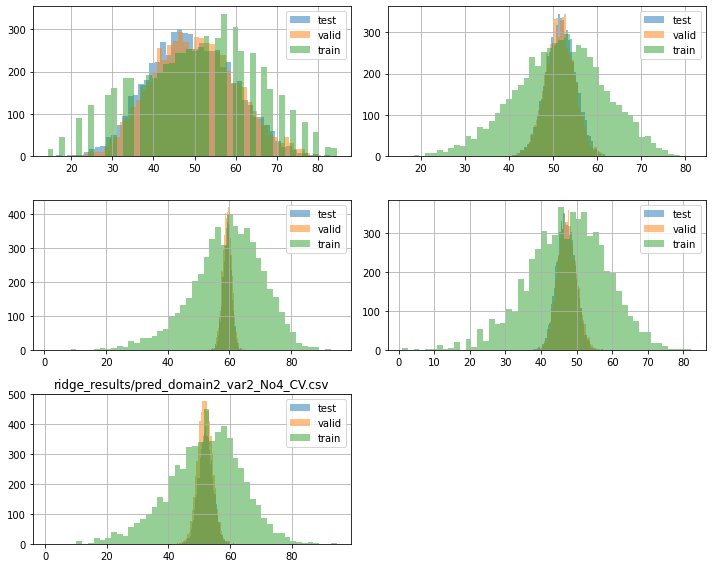

In [63]:
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.subplot(3, 2, i+1)
    test_df.iloc[:, i].hist(bins=50, alpha=0.5, label="test")
    val_df.iloc[:, i + 1].hist(bins=50, alpha=0.5, label="valid")
    df.iloc[:, i + 1].hist(bins=50, alpha=0.5, label="train")
    plt.legend()
plt.title(fname)
plt.tight_layout()
plt.savefig(f'pictures/{r_type}_No{file_No}.png')

In [64]:
list1 = os.listdir(config.root_test_path)
list2 = sorted(list1)
test_df["Id"] = list2
test_df["Id"] = test_df["Id"].map(lambda x: x[:-4])
test_df.set_index("Id", drop=True, inplace=True)
submission_file = f'ensemble/test_{r_type}_No{file_No}.csv'
test_df.to_csv(submission_file)

# %%
for i in range(5):
    test_df.rename(columns={test_df.columns[i]:config.target[i]}, inplace=True)
df_long = test_df.stack().reset_index()
df_long.rename(columns={'level_1': 'target', 0: 'Predicted'}, inplace=True)
df_long["Id"] = df_long["Id"] + "_" + df_long["target"]
df_long.drop("target", axis=1, inplace=True)
submission_file = f'submission/submission_{r_type}_No{file_No}.csv'
print(submission_file)
df_long.to_csv(submission_file, index=False)
df_long

submission/submission_ridge_No4.csv


,Id,Predicted
0,10003_age,57.700086
1,10003_domain1_var1,49.101541
2,10003_domain1_var2,60.380821
3,10003_domain2_var1,49.722179
4,10003_domain2_var2,57.232224
...,...,...
29380,21753_age,37.529131
29381,21753_domain1_var1,42.351245
29382,21753_domain1_var2,60.043251
29383,21753_domain2_var1,45.087772


In [65]:
test_df

,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
Id,,,,,
10003,57.700086,49.101541,60.380821,49.722179,57.232224
10006,62.085112,54.864415,58.716970,49.315098,52.217435
10010,37.291056,50.074439,60.100730,45.289990,53.464523
10011,51.740132,52.597179,60.594848,48.308601,50.541784
10012,52.440374,56.029637,55.438037,45.626669,58.833442
...,...,...,...,...,...
21745,39.776305,50.879096,58.128706,45.565379,53.899691
21748,55.390119,58.376674,60.192469,48.251085,52.166655
21749,39.932409,47.183197,58.848130,45.672301,51.837593


In [69]:
# # ここは正しいカラムに修正
# fnc = pd.read_csv("../input/trends-assessment-prediction/fnc.csv")
# loading = pd.read_csv("../input/trends-assessment-prediction/loading.csv")
# df = loading.merge(fnc, on="Id", how="left")
# columns = list(df.columns[1:])
# print(columns[:5], columns[-5:])


In [70]:
# to make json file for print columns

fnc_df = pd.read_csv("../input/trends-assessment-prediction/fnc.csv")
loading_df = pd.read_csv("../input/trends-assessment-prediction/loading.csv")

fnc_features, loading_features = list(fnc_df.columns[1:]), list(loading_df.columns[1:])
df = fnc_df.merge(loading_df, on="Id")


labels_df = pd.read_csv("../input/trends-assessment-prediction/train_scores.csv")
labels_df["is_train"] = True

df = df.merge(labels_df, on="Id", how="left")

test_df = df[df["is_train"] != True].copy()
test_Id = test_df["Id"]
is_train_idx = df["is_train"] == True
df = df[is_train_idx].copy()
FNC_SCALE = 1 / 600

df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE
all_features = fnc_features + loading_features
all_df = pd.concat([df.loc[:, fnc_features], test_df.loc[:, fnc_features]], axis=0)
# pca, ica
pca = PCA(n_components=300)
pca_all = pca.fit_transform(all_df)
scores = pca.explained_variance_ratio_
print(f"pca_all.shape:{pca_all.shape}, PCA:ratio:{scores.cumsum()[-1]:.5f}")
all_df = pd.concat([df.loc[:, loading_features], test_df.loc[:, loading_features]], axis=0)
ica = FastICA(n_components=26, random_state=seed)  # 26個の基底（コンポネント）を作る
ica_all = ica.fit_transform(all_df)
print(f"ica_all.shape:{ica_all.shape}")
# pca, icaを結合ラベル貼り
fnc_pca_labels = [f"fnc_pca_{i}" for i in range(pca_all.shape[1])]
loading_ica_labels = [f"loading_ica_{i}" for i in range(ica_all.shape[1])]
tmp1 = pd.DataFrame(pca_all, columns=fnc_pca_labels)
tmp2 = pd.DataFrame(ica_all, columns=loading_ica_labels)
all_df = pd.concat([tmp2, tmp1], axis=1)
# df = all_df[:5877].join(labels_df)
# test_df = all_df[5877:]
columns = list(all_df.columns)
print(columns[:5], columns[-5:])


pca_all.shape:(11754, 300), PCA:ratio:0.91496
ica_all.shape:(11754, 26)
['loading_ica_0', 'loading_ica_1', 'loading_ica_2', 'loading_ica_3', 'loading_ica_4'] ['fnc_pca_295', 'fnc_pca_296', 'fnc_pca_297', 'fnc_pca_298', 'fnc_pca_299']


In [71]:
n_features =[32, 249, 25, 92, 59]  # No.4
# n_features =[0, 236, 242, 59, 28]  # No2
targets = ["age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]
data = {}
for i in range(5):
    value = columns[:len(columns) - n_features[i]]
    key = f"{targets[i]}_No{file_No}_columns"
    data[key] = value


In [72]:
json_path = f"ensemble/ridge_No{file_No}_columns.json"
with open(json_path, 'w') as f:
    json.dump(data, f, indent=4)

In [42]:
with open(json_path) as f:
    df = json.load(f)
# df